## DIP Assignment 4

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Task 1: Image Segmentation Using Threshold-ing

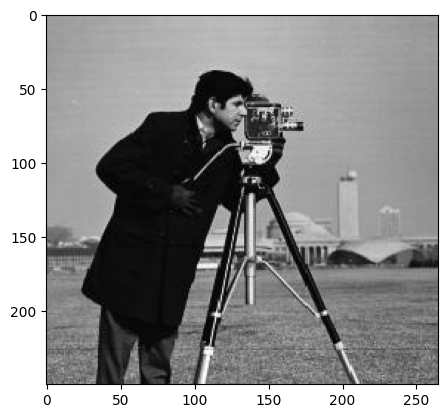

In [2]:
# load 1.png
img1 = cv2.imread("../data/1.png", cv2.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap="gray")
plt.show()

In [3]:
def binary_threshold(original, threshold):
    
    img = original.copy()
    
    img[img < threshold] = 0
    img[img >= threshold] = 255
    return img

In [4]:
def adaptive_threshold_custom(original, block_size, C, method="mean"):
    """
    Custom implementation of adaptive thresholding.

    Parameters:
    - image: Grayscale input image as a NumPy array.
    - block_size: Size of the neighborhood (must be odd).
    - C: Constant to subtract from the local mean/median.
    - method: 'mean' or 'median' for calculating local threshold.

    Returns:
    - Thresholded binary image as a NumPy array.
    """
    image = original.copy()
    
    # Ensure block_size is odd
    if block_size % 2 == 0:
        raise ValueError("block_size must be an odd number.")

    # Compute local statistics
    if method == "mean":
        local_mean = cv2.boxFilter(image, ddepth=-1, ksize=(block_size, block_size))
        local_thresh = local_mean - C
    elif method == "median":
        local_thresh = cv2.medianBlur(image, block_size) - C
    else:
        raise ValueError("Method must be 'mean' or 'median'.")

    # Apply thresholding
    binary_image = (image > local_thresh).astype(np.uint8) * 255

    return binary_image

In [5]:
def otsu_threshold(original):
    """
    Perform Otsu's thresholding on a grayscale image.
    
    Parameters:
        image (numpy.ndarray): Grayscale input image (2D array).
        
    Returns:
        threshold (int): The calculated threshold value.
        binary_image (numpy.ndarray): The binary image obtained after thresholding.
    """
    image = original.copy()
    
    # Flatten the image to calculate histogram
    pixel_values = image.ravel()
    hist, bin_edges = np.histogram(pixel_values, bins=256, range=(0, 256))
    
    # Calculate the cumulative sums and means
    total_pixels = pixel_values.size
    cumulative_sum = np.cumsum(hist)
    cumulative_mean = np.cumsum(hist * np.arange(256))
    global_mean = cumulative_mean[-1] / total_pixels  # Mean of the entire image
    
    # Compute between-class variance for each threshold
    between_class_variance = (
        (global_mean * cumulative_sum - cumulative_mean)**2 / 
        (cumulative_sum * (total_pixels - cumulative_sum) + 1e-10)  # Avoid division by zero
    )
    
    # Find the threshold that maximizes between-class variance
    optimal_threshold = np.argmax(between_class_variance)
    
    # Apply the threshold to create the binary image
    binary_image = (image > optimal_threshold).astype(np.uint8) * 255
    
    return optimal_threshold, binary_image

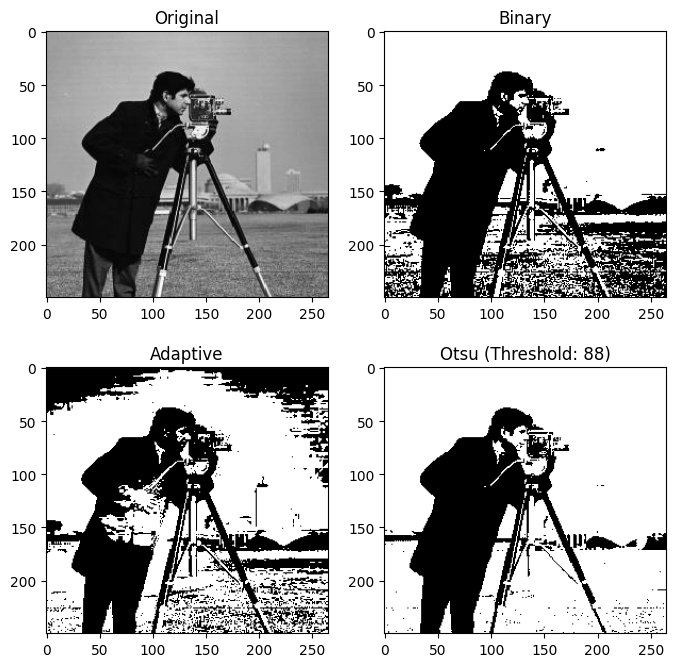

In [6]:
# binary thresholding
img1_binary = binary_threshold(img1, 128)

# adaptive thresholding
C = 5
block_size = 131
img1_adaptive = adaptive_threshold_custom(img1, block_size, C, method="median")

# Otsu's thresholding
optimal_threshold, binary_image = otsu_threshold(img1)

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(img1, cmap="gray")
plt.title(f"Original")

plt.subplot(2, 2, 2)
plt.imshow(img1_binary, cmap="gray")
plt.title(f"Binary")

plt.subplot(2, 2, 3)
plt.imshow(img1_adaptive, cmap="gray")
plt.title(f"Adaptive")

plt.subplot(2, 2, 4)
plt.imshow(binary_image, cmap='gray')
plt.title(f"Otsu (Threshold: {optimal_threshold})")

plt.show()

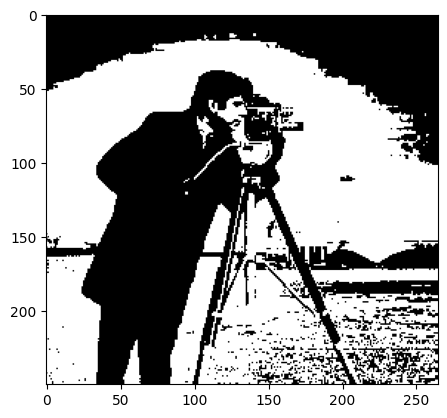

In [7]:
C = 5
block_size = 131

cv2_adaptive = cv2.adaptiveThreshold(
    img1, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C
)

plt.imshow(cv2_adaptive, cmap="gray")

> (c) In 2-3 sentences, discuss which method provided the best segmentation for your image and why. Consider factors like clarity of object boundaries and noise levels.

---
### Task 2: Line Detection Using Hough Transform

In [42]:
from math import sin, cos

In [43]:
img_building = cv2.imread("../data/building.jpg", cv2.IMREAD_COLOR)
img_building = cv2.resize(img_building, (img_building.shape[1]//2, img_building.shape[0]//2))


original_image = img_building
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray_image, 100, 500)

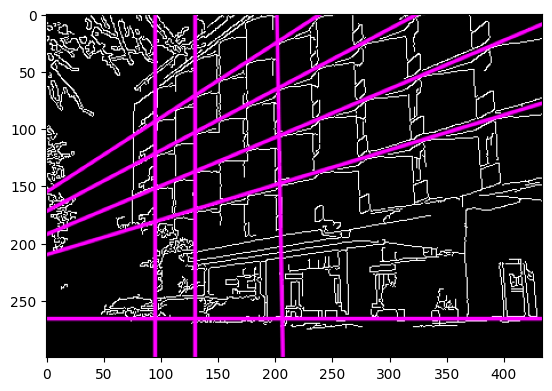

In [44]:
src = img_building.copy()
dst = edges.copy()

# Copy edges to the images that will display the results in BGR
img2_canny = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
dstp = img2_canny.copy()

# Lets apply Standard HoughLine transform to detect lines
lines = cv2.HoughLines(dst, 0.7, np.pi / 180, 105, None, 0, 0)

# Below we will display the result by drawing lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = cos(theta)
        b = sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        cv2.line(dstp, pt1, pt2, (255, 0, 255), 2, cv2.LINE_AA)

# cv2.imshow("Source", src)
plt.imshow(dstp)

---

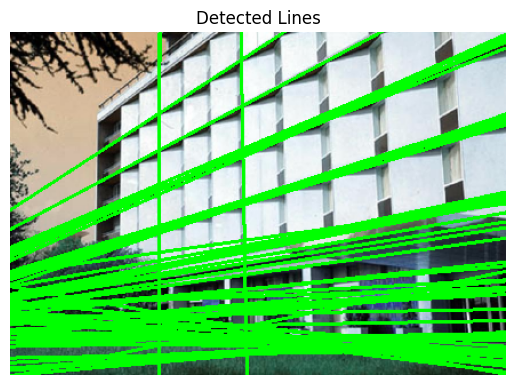

In [121]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_hough_accumulator(img, rho=1, theta=np.pi/180):
    """
    Computes the Hough Accumulator for a given edge-detected image.
    Corresponds to OpenCV's `cv2.HoughLines` parameters.
    
    Parameters:
        img (ndarray): Binary edge image.
        rho (int): Resolution of the accumulator in pixels.
        theta (float): Resolution of the accumulator in radians.

    Returns:
        H (ndarray): Hough accumulator array.
        rhos (ndarray): Range of rho values.
        thetas (ndarray): Range of theta values (in radians).
    """
    height, width = img.shape
    diag_len = int(np.ceil(np.sqrt(height**2 + width**2)))
    rhos = np.arange(-diag_len, diag_len + 1, rho)
    thetas = np.arange(-np.pi / 2, np.pi / 2, theta)
    
    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)  # Get coordinates of edge pixels
    
    for x, y in zip(x_idxs, y_idxs):
        for theta_idx, theta_value in enumerate(thetas):
            rho_value = int(x * np.cos(theta_value) + y * np.sin(theta_value) + diag_len)
            H[rho_value, theta_idx] += 1
    
    return H, rhos, thetas

def find_hough_peaks(H, threshold=0):
    """
    Identifies peaks in the Hough accumulator.
    Corresponds to OpenCV's `cv2.HoughLines` threshold parameter.
    
    Parameters:
        H (ndarray): Hough accumulator array.
        threshold (int): Minimum number of votes to consider a line as detected.

    Returns:
        peaks (list): List of peak indices [(rho_idx, theta_idx), ...].
    """
    peaks = []
    
    # Loop through the accumulator and find indices where votes exceed the threshold
    for rho_idx in range(H.shape[0]):
        for theta_idx in range(H.shape[1]):
            if H[rho_idx, theta_idx] >= threshold:
                peaks.append((rho_idx, theta_idx))
    
    return peaks

def draw_hough_lines(img, peaks, rhos, thetas):
    """
    Draws lines on an image based on the peaks from the Hough accumulator.
    Corresponds to `cv2.HoughLines` behavior for drawing lines.
    
    Parameters:
        img (ndarray): Image on which to draw lines.
        peaks (list): List of peak indices [(rho_idx, theta_idx), ...].
        rhos (ndarray): Range of rho values.
        thetas (ndarray): Range of theta values.
    """
    for rho_idx, theta_idx in peaks:
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * a)
        x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * a)
        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

def plot_hough_space(H):
    """
    Displays the Hough accumulator using Matplotlib.
    Corresponds to visualization of the accumulator space.
    
    Parameters:
        H (ndarray): Hough accumulator array.
    """
    plt.imshow(H, cmap='jet', aspect='auto')
    plt.title("Hough Accumulator")
    plt.xlabel('Theta (radians)')
    plt.ylabel('Rho (pixels)')
    plt.colorbar()
    plt.show()

# Load edge-detected image
original_img = img_building.copy()  # Replace with actual input image
edge_img = edges.copy()  # Replace with edge-detected image (e.g., from Canny)

# Compute Hough Transform
H, rhos, thetas = compute_hough_accumulator(edge_img, rho=1, theta=np.pi/180)

# Identify peaks based on a threshold
peaks = find_hough_peaks(H, threshold=150)

# Plot Hough accumulator
# plot_hough_space(H)

# Draw lines on the image based on detected peaks
draw_hough_lines(original_img, peaks, rhos, thetas)

# Show the result
plt.imshow(original_img)
plt.axis('off')
plt.title("Detected Lines")
plt.show()


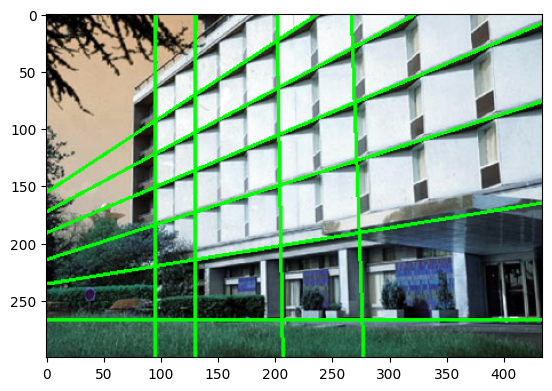

In [ ]:
# Step 1: The Hough transform needs a binary edges images.  For this particular
# python file, I used the openCV built in Class Canny to create this edge image
# from the original shapes.png file.

# This is the function that will build the Hough Accumulator for the given image
def hough_lines_acc(img, rho_resolution=1, theta_resolution=1):
    ''' A function for creating a Hough Accumulator for lines in an image. '''
    height, width = img.shape # we need heigth and width to calculate the diag
    img_diagonal = np.ceil(np.sqrt(height**2 + width**2)) # a**2 + b**2 = c**2
    rhos = np.arange(-img_diagonal, img_diagonal + 1, rho_resolution)
    thetas = np.deg2rad(np.arange(-90, 90, theta_resolution))

    # create the empty Hough Accumulator with dimensions equal to the size of
    # rhos and thetas
    H = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img) # find all edge (nonzero) pixel indexes

    for i in range(len(x_idxs)): # cycle through edge points
        x = x_idxs[i]
        y = y_idxs[i]

        for j in range(len(thetas)): # cycle through thetas and calc rho
            rho = int((x * np.cos(thetas[j]) +
                       y * np.sin(thetas[j])) + img_diagonal)
            H[rho, j] += 1

    return H, rhos, thetas


# This is a simple peaks function that just finds the indicies of the number
# of maximum values equal to num_peaks.  You have to be careful here though, if
# there's any noise in the image it will like create a 'pocket' of local maxima
# values.  This function ignores this and in turn has the tendancy to return
# multiple lines along an actual line in the image.
def hough_simple_peaks(H, num_peaks):
    ''' A function that returns the number of indicies = num_peaks of the
        accumulator array H that correspond to local maxima. '''
    indices =  np.argpartition(H.flatten(), -2)[-num_peaks:]
    return np.vstack(np.unravel_index(indices, H.shape)).T


# This more advance Hough peaks funciton has threshold and nhood_size arguments
# threshold will threshold the peak values to be above this value if supplied,
# where as nhood_size will surpress the surrounding pixels centered around
# the local maximum after that value has been assigned as a peak.  This will
# force the algorithm to look eslwhere after it's already selected a point from
# a 'pocket' of local maxima.
def hough_peaks(H, num_peaks, threshold=0, nhood_size=3):
    ''' A function that returns the indicies of the accumulator array H that
        correspond to a local maxima.  If threshold is active all values less
        than this value will be ignored, if neighborhood_size is greater than
        (1, 1) this number of indicies around the maximum will be surpessed. '''
    # loop through number of peaks to identify
    indicies = []
    H1 = np.copy(H)
    for i in range(num_peaks):
        idx = np.argmax(H1) # find argmax in flattened array
        H1_idx = np.unravel_index(idx, H1.shape) # remap to shape of H
        
        if H1.flat[idx] < threshold:  # Stop if the max value is below the threshold
            break
        
        indicies.append(H1_idx)

        # surpess indicies in neighborhood
        idx_y, idx_x = H1_idx # first separate x, y indexes from argmax(H)
        # if idx_x is too close to the edges choose appropriate values
        if (idx_x - (nhood_size//2)) < 0: min_x = 0
        else: min_x = idx_x - (nhood_size//2)
        if ((idx_x + (nhood_size//2) + 1) > H.shape[1]): max_x = H.shape[1]
        else: max_x = idx_x + (nhood_size//2) + 1

        # if idx_y is too close to the edges choose appropriate values
        if (idx_y - (nhood_size//2)) < 0: min_y = 0
        else: min_y = idx_y - (nhood_size//2)
        if ((idx_y + (nhood_size//2) + 1) > H.shape[0]): max_y = H.shape[0]
        else: max_y = idx_y + (nhood_size//2) + 1

        # bound each index by the neighborhood size and set all values to 0
        for x in range(min_x, max_x):
            for y in range(min_y, max_y):
                # remove neighborhoods in H1
                H1[y, x] = 0

                # highlight peaks in original H
                if (x == min_x or x == (max_x - 1)):
                    H[y, x] = 255
                if (y == min_y or y == (max_y - 1)):
                    H[y, x] = 255

    # return the indicies and the original Hough space with selected points
    return indicies, H


# a simple funciton used to plot a Hough Accumulator
def plot_hough_acc(H, plot_title='Hough Accumulator Plot'):
    ''' A function that plot a Hough Space using Matplotlib. '''
    plt.imshow(H, cmap='jet')

    plt.xlabel('Theta Direction'), plt.ylabel('Rho Direction')
    plt.tight_layout()
    plt.show()


# drawing the lines from the Hough Accumulatorlines using OpevCV cv2.line
def hough_lines_draw(img, indicies, rhos, thetas):
    ''' A function that takes indicies a rhos table and thetas table and draws
        lines on the input images that correspond to these values. '''
    for i in range(len(indicies)):
        # reverse engineer lines from rhos and thetas
        rho = rhos[indicies[i][0]]
        theta = thetas[indicies[i][1]]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        # these are then scaled so that the lines go off the edges of the image
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

shapes = img_building.copy()
canny_edges = edges.copy()
# run hough_lines_accumulator on the shapes canny_edges image
H, rhos, thetas = hough_lines_acc(img=canny_edges, rho_resolution=1, theta_resolution=np.pi/3)
indicies, H = hough_peaks(H=H, num_peaks=10, threshold=50, nhood_size=20) # find peaks
# plot_hough_acc(H) # plot hough space, brighter spots have higher votes
hough_lines_draw(shapes, indicies, rhos, thetas)

# Show image with manual Hough Transform Lines
plt.imshow(shapes)
plt.show()

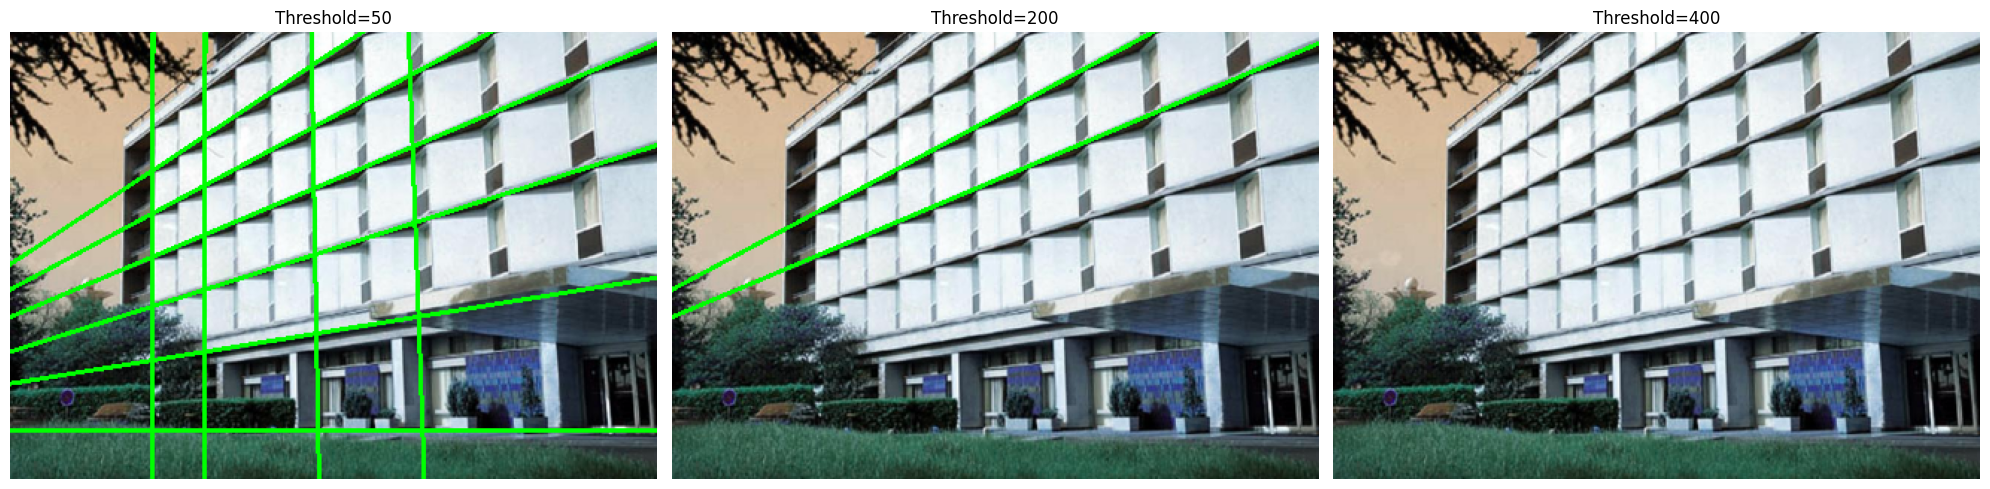

In [57]:
# Experiment with different threshold values
threshold_values = [50, 200, 400]

fig, axes = plt.subplots(1, len(threshold_values), figsize=(20, 10))

for idx, threshold in enumerate(threshold_values):

    original_image = img_building.copy()
    img = canny_edges.copy()

    H, rhos, thetas = hough_lines_acc(
        img=img, rho_resolution=1, theta_resolution=np.pi / 3
    )
    indicies, H = hough_peaks(
        H=H, num_peaks=10, threshold=threshold, nhood_size=20
    )  # find peaks
    # plot_hough_acc(H) # plot hough space, brighter spots have higher votes
    hough_lines_draw(original_image, indicies, rhos, thetas)

    # axes[0, idx].imshow(edges, cmap='gray')
    # axes[0, idx].set_title(f'k={k}')
    # axes[0, idx].axis('off')

    axes[idx].imshow(original_image)
    axes[idx].set_title(f"Threshold={threshold}")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

> In 2-3 sentences, describe the parameter changes and how they affected the results. 

---
###Task 3: Circle Detection Using Hough CircleTransform

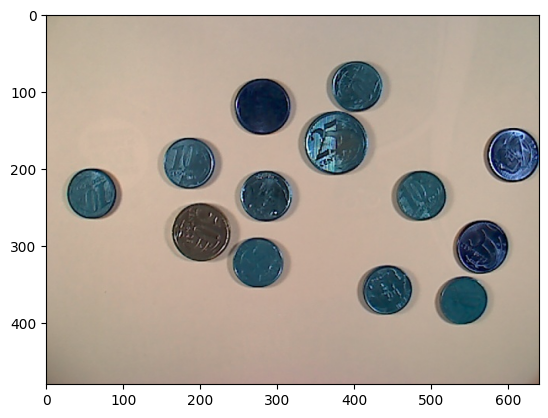

In [3]:
img_coins = cv2.imread("../data/coins.jpg", cv2.IMREAD_COLOR)
img_coins = cv2.cvtColor(img_coins, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_coins, cv2.COLOR_BGR2GRAY)

plt.imshow(cv2.cvtColor(img_coins, cv2.COLOR_BGR2RGB))

In [4]:
from scipy import ndimage

Number of circles detected: 13


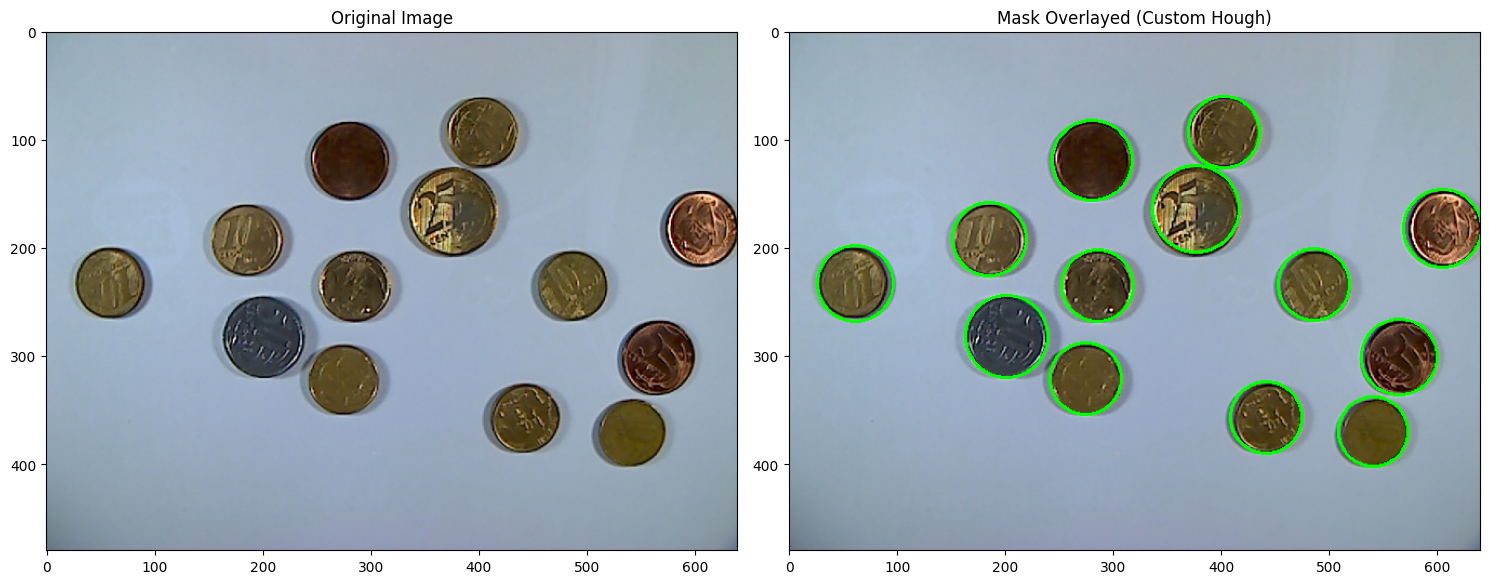

In [30]:
def initialize_accumulator(image_shape, dp, min_radius, max_radius):
    h, w = image_shape
    accumulator_h, accumulator_w = h // dp, w // dp
    radii = np.arange(min_radius, max_radius + 1)
    num_radii = len(radii)

    # Initialize accumulator array (height, width, number of radii)
    return np.zeros((accumulator_h, accumulator_w, num_radii), dtype=np.int32), radii


def accumulate_votes(edges, radii, dp, accumulator):
    y, x = np.where(edges > 0)

    # Precompute the sine and cosine values for all angles (0 to 2*pi)
    t = np.linspace(0, 2 * np.pi, 180)
    cos_t = np.cos(t)
    sin_t = np.sin(t)

    for i, r in enumerate(radii):
        x_offsets = (x[:, np.newaxis] - r * cos_t) / dp
        y_offsets = (y[:, np.newaxis] - r * sin_t) / dp

        x_idxs = np.floor(x_offsets).astype(int)
        y_idxs = np.floor(y_offsets).astype(int)

        # Valid indices within bounds
        valid = (
            (x_idxs >= 0)
            & (x_idxs < accumulator.shape[1])
            & (y_idxs >= 0)
            & (y_idxs < accumulator.shape[0])
        )
        np.add.at(accumulator, (y_idxs[valid], x_idxs[valid], i), 1)


def find_local_maxima(accumulator, threshold=100):
    local_max = (accumulator == ndimage.maximum_filter(accumulator, size=(3, 3, 3))) & (
        accumulator > threshold
    )
    return np.argwhere(local_max)


def filter_and_sort_circles(circles, min_dist):
    if circles.size > 0:
        # Sort circles by radius in descending order
        circles = circles[np.argsort(circles[:, 2])[::-1]]
        filtered_circles = []

        for circle in circles:
            if all(
                np.linalg.norm(circle[:2] - c[:2]) >= min_dist for c in filtered_circles
            ):
                filtered_circles.append(circle)

        return np.array(filtered_circles)
    return circles


def hough_circles(image, dp, minDist, param1=100, param2=100, minRadius=0, maxRadius=0):
    # Step 1: Apply edge detection
    edges = cv2.Canny(image, 50, 100)

    # Step 2: Initialize accumulator
    maxRadius = maxRadius or min(edges.shape) // 2
    minRadius = minRadius or 1
    accumulator, radii = initialize_accumulator(edges.shape, dp, minRadius, maxRadius)

    # Step 3: Accumulate votes
    accumulate_votes(edges, radii, dp, accumulator)

    # Step 4: Find local maxima in the accumulator
    local_max_coords = find_local_maxima(accumulator, param2)

    # Step 5: Extract and filter circles
    circles = [(int(x * dp), int(y * dp), radii[r]) for y, x, r in local_max_coords]
    circles = np.array(circles)
    circles = filter_and_sort_circles(circles, minDist)

    return circles


def plot_results(img, result, circles):
    print("Number of circles detected:", circles.shape[0])

    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")

    plt.subplot(122)
    plt.imshow(result, cmap="gray")
    plt.title("Mask Overlayed (Custom Hough)")

    plt.tight_layout()
    plt.show()


# Example usage
img = img_gray.copy()  # Replace with your actual grayscale image

_, img_thresholded = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Call custom Hough Circles function
circles = hough_circles(
    img_thresholded, dp=1, param1=1, param2=70, minDist=30, minRadius=30, maxRadius=40
)

# Create mask to visualize detected circles
output_img = img_coins.copy()
for circle in circles.astype(int):
    x, y, r = circle
    cv2.circle(output_img, (x, y), r, (0, 255, 0), 2)

# Plot the results
plot_results(img_coins, output_img, circles)

Varying thresholds

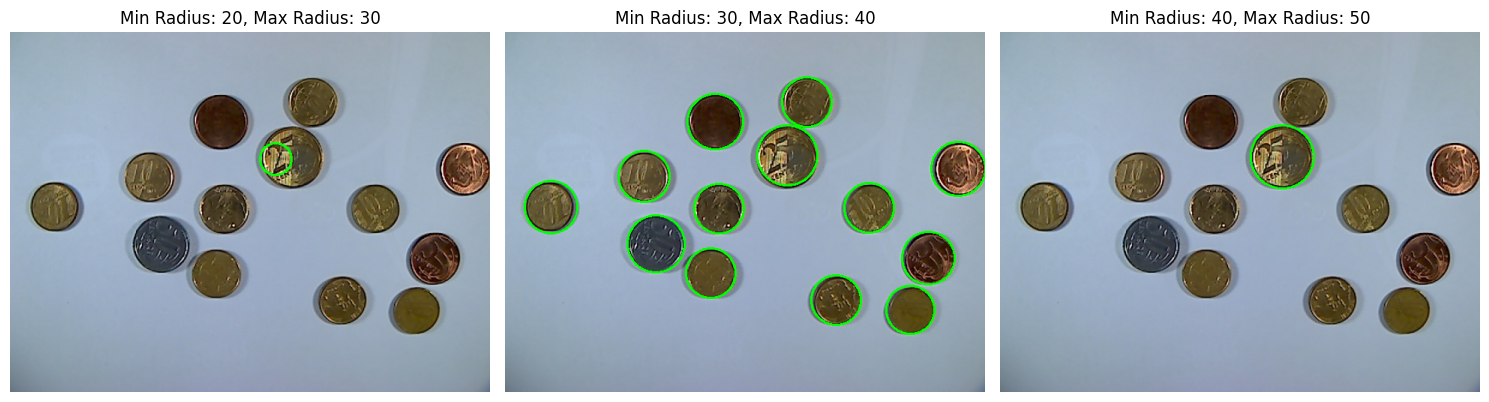

In [ ]:
min_radii = [20, 30, 40] 
max_radii = [30, 40, 50]

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for idx, (min_radius, max_radius, threshold) in enumerate(zip(min_radii, max_radii, threshold_values)):
    circles = hough_circles(
        img_thresholded,
        dp=1,
        param2=70,
        minDist=30,
        minRadius=min_radius,
        maxRadius=max_radius,
    )

    output_img = img_coins.copy()
    for circle in circles.astype(int):
        x, y, r = circle
        cv2.circle(output_img, (x, y), r, (0, 255, 0), 2)

    axes[idx % 3].imshow(output_img)
    axes[idx % 3].set_title(f"Min Radius: {min_radius}, Max Radius: {max_radius}")
    axes[idx % 3].axis("off")
    
plt.tight_layout()
plt.show()

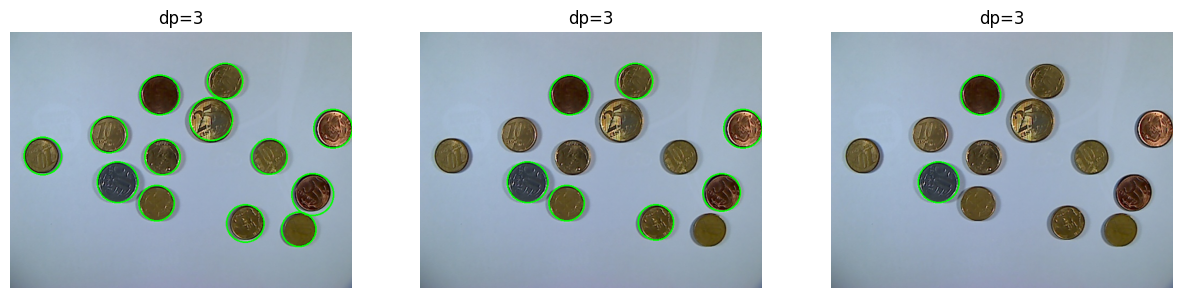

In [34]:
threshold_values = [60, 90, 120]

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for idx, threshold in enumerate(threshold_values):
    circles = hough_circles(
        img_thresholded,
        dp=1,
        param2=threshold,
        minDist=30,
        minRadius=30,
        maxRadius=40,
    )

    output_img = img_coins.copy()
    for circle in circles.astype(int):
        x, y, r = circle
        cv2.circle(output_img, (x, y), r, (0, 255, 0), 2)

    axes[idx % 3].imshow(output_img)
    axes[idx % 3].set_title(f"dp={dp}")
    axes[idx % 3].axis("off")
    
plt.show() 

> briefly explain any improvements observed

---
### Task 4: Harris Corner Detection

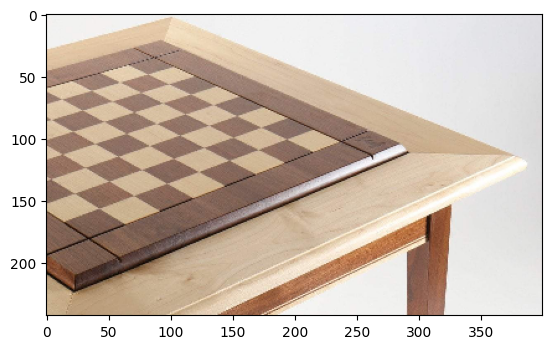

In [39]:
chess_img = cv2.imread("../data/chess.jpg", cv2.IMREAD_COLOR)
chess_img = cv2.cvtColor(chess_img, cv2.COLOR_BGR2RGB)
chess_img = cv2.resize(chess_img, (chess_img.shape[1]//3, chess_img.shape[0]//3))

plt.imshow(chess_img)

In [88]:
import cv2
import numpy as np

def harris_corner_detection(image, k=0.04, threshold=0.01, nms_window_size=5):
    """
        k (float): Sensitivity factor to separate corners from edges.
        threshold (float): Threshold for detecting corners.
        nms_window_size (int): Window size for non-maximum suppression.
    """
    gray = np.float32(image)

    # Compute gradients using Sobel
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Compute products of derivatives and smooth them
    Ixx = cv2.GaussianBlur(Ix * Ix, (3, 3), 1)
    Iyy = cv2.GaussianBlur(Iy * Iy, (3, 3), 1)
    Ixy = cv2.GaussianBlur(Ix * Iy, (3, 3), 1)

    # Compute the Harris corner response
    det = (Ixx * Iyy) - (Ixy * Ixy)
    trace = Ixx + Iyy
    harris_response = det - k * (trace ** 2)

    # Threshold and Non-Maximum Suppression (NMS)
    corners = apply_threshold_and_nms(harris_response, threshold, nms_window_size)

    # Mark corners on the original image
    marked_image = mark_corners_on_image(image, corners)

    return marked_image, corners


def apply_threshold_and_nms(response, threshold, nms_window_size):
    
    # Threshold the response
    threshold_value = threshold * response.max()
    binary_response = (response > threshold_value).astype(np.uint8)

    # Non-Maximum Suppression (NMS)
    dilated_response = cv2.dilate(response, cv2.getStructuringElement(cv2.MORPH_RECT, (nms_window_size, nms_window_size)))
    nms_mask = (response == dilated_response) & (binary_response > 0)

    # Convert to binary image
    corners = (nms_mask).astype(np.uint8) * 255

    return corners


def mark_corners_on_image(image, corners):

    # Convert grayscale to BGR
    marked_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Mark corners in red by putting a red circle over them
    for y, x in zip(*np.where(corners > 0)):
        cv2.circle(marked_image, (x, y), 2, (255, 0, 0), -1)
        

    return marked_image


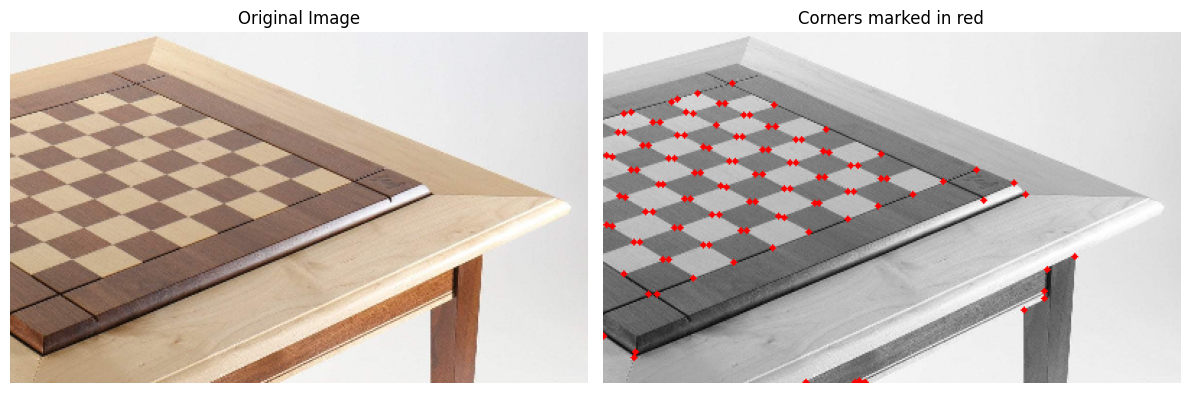

In [89]:
result, corners = harris_corner_detection(
    cv2.cvtColor(chess_img, cv2.COLOR_RGB2GRAY),
    k=0.04,
    threshold=0.01,
    nms_window_size=5,
)
# Display the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(chess_img)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(result)
axes[1].set_title("Corners marked in red")
axes[1].axis("off")

plt.tight_layout()
plt.show()

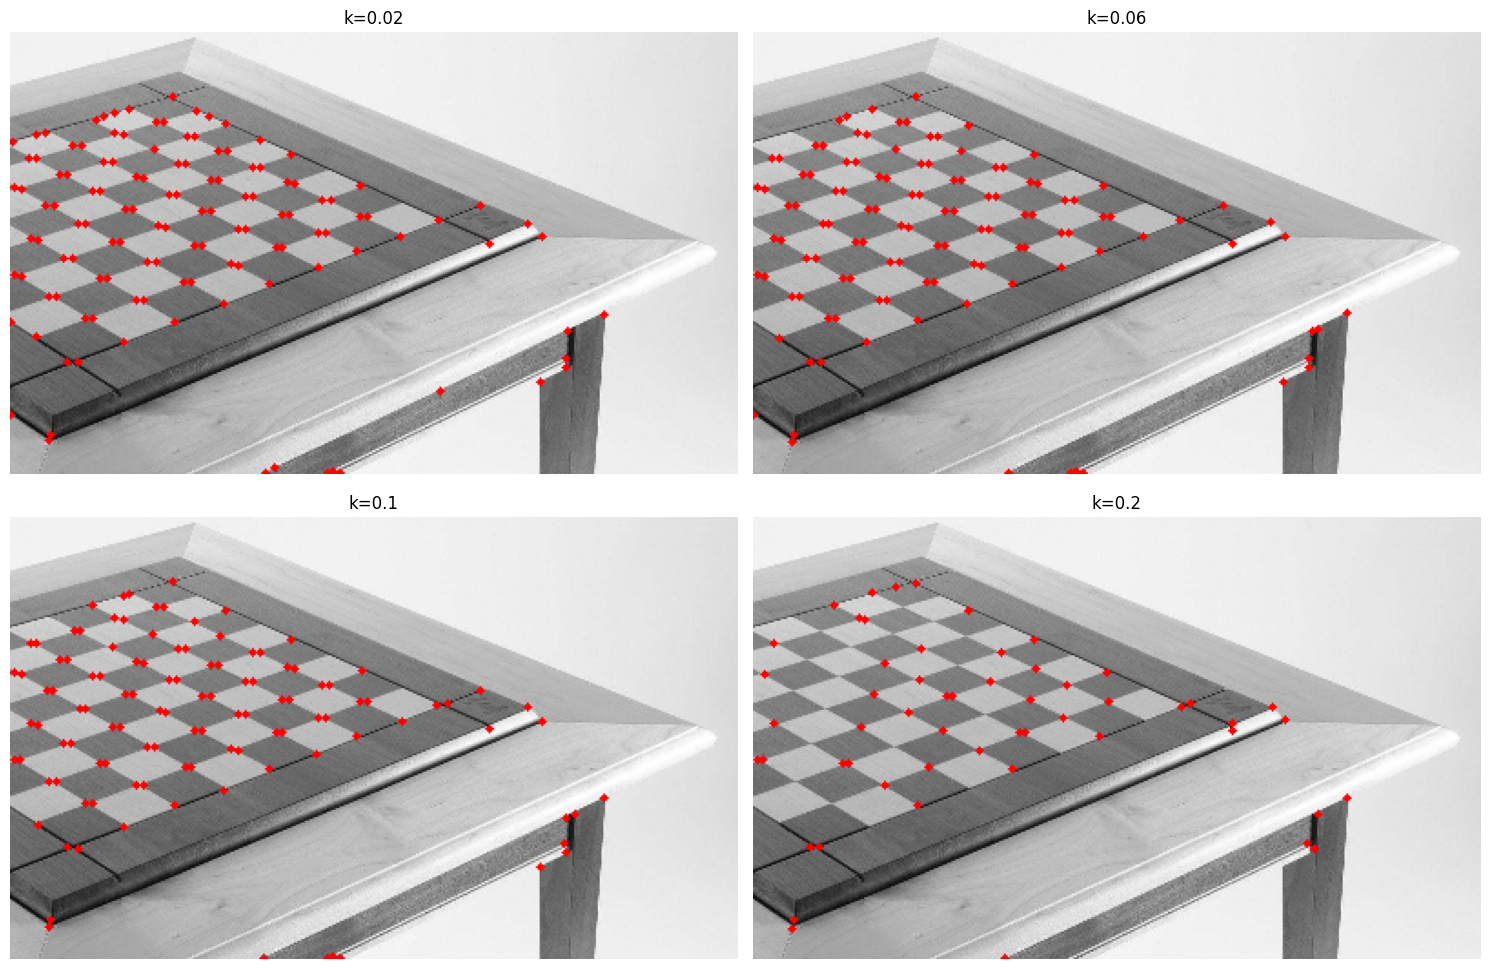

In [96]:
k_values = [0.02, 0.06, 0.1, 0.2]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, k in enumerate(k_values):
    result, corners = harris_corner_detection(
        cv2.cvtColor(chess_img, cv2.COLOR_RGB2GRAY),
        k=k,
        threshold=0.01,
        nms_window_size=5,
    )

    row, col = divmod(idx, 2)
    axes[row, col].imshow(result)
    axes[row, col].set_title(f"k={k}")
    axes[row, col].axis("off")
    
plt.tight_layout()  
plt.show()